In [1]:
# Name: Brian Aspinwall
# This project aims to determine whether or not a classification model can
# be used to accurately identify sarcasm if/when it appears in news article
# headlines.  The input data is sourced from kaggle and is a json file containing 
# ~25 000 entries in it, each with 3 fields: article_link, headline,
# and is_sarcastic.  Only the headline field, containing headline text,
# and the is_sarcastic field, denoting if a headline is sarcastic,
# are used for the project.  I chose this project because I thought that
# sarcasm would be a difficult form of language to identify by machine 
# learning models due to its relative complexity, and I wanted to see
# how well a basic classification model would be able to function with it.

In [2]:
#sources used: kaggle.com, pandas api, classnotes 
#(preprocessing methodology and vectorization)
#https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection?select=Sarcasm_Headlines_Dataset_v2.json

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

#nltk.download('punkt')
#nltk.download('stopwords')

In [4]:
#create dataframe, check for nan, remove unnecessary columns, show data

In [5]:
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df = df[["headline","is_sarcastic"]]
print(df.isna().sum())
print(df.shape)
df.head()

headline        0
is_sarcastic    0
dtype: int64
(26709, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
#show basic statistics

In [7]:
sarc = df[df.is_sarcastic == 1]
nonSarc = df[df.is_sarcastic == 0]
print(100 * nonSarc.size / df.size, "% are not sarcastic")
print(100 * sarc.size / df.size, "% are sarcastic")

56.10468381444457 % are not sarcastic
43.89531618555543 % are sarcastic


In [8]:
#start work to show freq distributions for sarc/nonsarc headlines
#remove punctuation/stop words

In [9]:
tokenizer = RegexpTokenizer('\w+') #remove non words
stop_words = set(stopwords.words("english"))

sarcWords = [w for w in tokenizer.tokenize(' '.join(sarc["headline"])) if w not in stop_words]
nonSarcWords = [w for w in tokenizer.tokenize(' '.join(nonSarc["headline"])) if w not in stop_words]


In [10]:
#show distributions

In [11]:
sarcFreqDist = nltk.FreqDist(sarcWords)
nonSarcFreqDist = nltk.FreqDist(nonSarcWords)
display(sarcFreqDist.most_common(20))
display(nonSarcFreqDist.most_common(20))

[('man', 1154),
 ('new', 843),
 ('area', 480),
 ('report', 426),
 ('nation', 339),
 ('woman', 319),
 ('year', 308),
 ('one', 273),
 ('old', 267),
 ('time', 252),
 ('day', 245),
 ('trump', 238),
 ('study', 213),
 ('still', 212),
 ('u', 207),
 ('like', 194),
 ('first', 193),
 ('get', 190),
 ('back', 189),
 ('family', 186)]

[('trump', 1446),
 ('new', 680),
 ('donald', 458),
 ('says', 349),
 ('women', 317),
 ('one', 268),
 ('u', 263),
 ('year', 244),
 ('first', 242),
 ('world', 241),
 ('man', 241),
 ('people', 241),
 ('obama', 235),
 ('day', 226),
 ('make', 217),
 ('gop', 215),
 ('like', 213),
 ('5', 212),
 ('black', 208),
 ('get', 207)]

In [12]:
#plot distributions

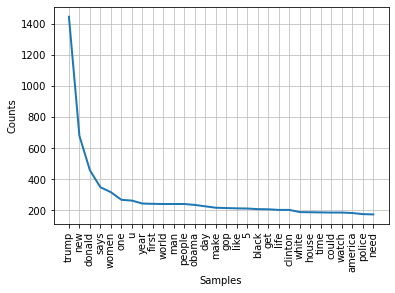

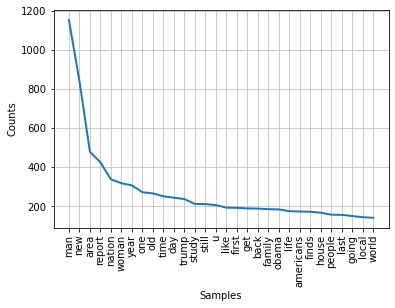

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [13]:
nonSarcFreqDist.plot(30)
sarcFreqDist.plot(30)

In [14]:
#build X dataset in preparation for analysis

In [15]:
X = df["headline"].to_frame()
X

,headline
0,former versace store clerk sues over secret 'b...
1,the 'roseanne' revival catches up to our thorn...
2,mom starting to fear son's web series closest ...
3,"boehner just wants wife to listen, not come up..."
4,j.k. rowling wishes snape happy birthday in th...
...,...
26704,american politics in moral free-fall
26705,america's best 20 hikes
26706,reparations and obama
26707,israeli ban targeting boycott supporters raise...


In [16]:
#preprocess data, tokenizing with words only, lowercased, stopwords
#removed, and stemmed

In [17]:
stemmer = PorterStemmer()

def preprocess(s) :
    w = tokenizer.tokenize(s.lower())         # separate into words and lowercase each word
    w = [word for word in w if word not in stop_words]    # remove stop words
    w = [stemmer.stem(word) for word in w]    # find stem of each word
    return ' '.join(w)         # join back into a string

# with each row, preprocess the text string, and store it in the X DataFrame
X_processed = pd.Series([preprocess(X.loc[i,'headline']) for i in range(len(X))]).to_frame()
X_processed.head()   

,0
0,former versac store clerk sue secret black cod...
1,roseann reviv catch thorni polit mood better wors
2,mom start fear son web seri closest thing gran...
3,boehner want wife listen come altern debt redu...
4,j k rowl wish snape happi birthday magic way


In [18]:
#vectorize x set

In [19]:
vectorizer = CountVectorizer()
vectorizer.fit(X_processed[0])
X_vectors = vectorizer.transform(X_processed[0])
print(X_vectors[0])
X_vectors.shape

  (0, 1827)	1
  (0, 3126)	1
  (0, 3215)	1
  (0, 5956)	1
  (0, 9896)	1
  (0, 13561)	1
  (0, 13843)	1
  (0, 14708)	1
  (0, 14878)	1
  (0, 16457)	1


(26709, 17320)

In [20]:
#build y set

In [21]:
y = df["is_sarcastic"]
y

0        0
1        0
2        1
3        1
4        0
        ..
26704    0
26705    0
26706    0
26707    0
26708    0
Name: is_sarcastic, Length: 26709, dtype: int64

In [22]:
#split the sets

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_vectors,y,test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21367, 17320) (21367,) (5342, 17320) (5342,)


In [24]:
#train multinomial naive bayes classifier with data
#and predict based on test split set

In [25]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [26]:
#show accuracy, confusion matrix, f score

In [27]:
print(metrics.accuracy_score(y_test, y_pred))
display(metrics.confusion_matrix(y_test, y_pred, labels=[0,1]))
print(f"score: {f1_score(y_test, y_pred, average='weighted'):.3f}")

0.7985773118682141


array([[2502,  491],
       [ 585, 1764]])

score: 0.798


In [1]:
#The results for accuracy and f1 score are reasonably promising at ~80% for both.
#From the f1 score and accuracy matching up at 80%,the model performs
#approximately equally precision and recall wise, with both at a reasonable proficiency.
#Precision and recall being reasonable means the model "caught" most positive values
#and made relatively few incorrect positive predictions.
#The confusion matrix shows that there is a slightly greater proportion of false
#positive predictions on sarcastic headlines as opposed to non sarcastic ones, but both are 
#reasonable, with roughly ~1/4 of sarcastic predictions being incorrect, and ~1/5 
#non sarcastic predictions being incorrect.  The model similarly "caught" a greater proportion
#of the nonsarcastic headlines than sarcastic ones.

In [29]:
#Overall, for a model aimed purely at identifying sarcastic headlines,
#the model was somewhat lacking, catching only 1764/2349, or approximately 75% of the sarcastic headlines,
#but it showed promise, and slightly superior proficiency in predicting non sarcastic headlines.
#The data set didn't seem significantly flawed, but seems to have taken most if not all
#sarcastic headlines from the onion.  This could potentially add bias to certain forms of 
#sarcasm/ignore others, affecting the viability of the model in identifying 
#headlines from other sources.
#One way to improve the project would be to hand build a data set using newsapi
#to import article headlines and then review them for sarcasm, although it 
#would be time consuming.